In [1]:
!make -C .. agglom_extent

make: Entering directory '/home/martibosch/data-science/lausanne-agglom-extent'
make: Nothing to be done for 'agglom_extent'.
make: Leaving directory '/home/martibosch/data-science/lausanne-agglom-extent'


In [2]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from rasterio import features, plot, warp

from lausanne_agglom_extent import utils

In [3]:
WEB_MERCATOR_CRS = 'epsg:3857'

esri_relief_uri = 'https://server.arcgisonline.com/ArcGIS/rest/services/' \
    'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}'
swiss_bounds_uri = 'https://raw.githubusercontent.com/ZHB/' \
    'switzerland-geojson/master/country/switzerland.geojson'

cadastre_filepath = '../data/interim/cadastre.shp'
agglom_extent_filepath = '../data/processed/agglom-extent.shp'

Read the agglomeration extent shapefile, which has been computed with the [Urban footprinter](https://github.com/martibosch/urban-footprinter) library following the methods used in the [Atlas of Urban Expansion](http://atlasofurbanexpansion.org/).

In [4]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath).to_crs(
    WEB_MERCATOR_CRS)

Rasterize the cadastre

In [5]:
cadastre_arr, cadastre_transform = utils.rasterize_cadastre(
    cadastre_filepath, dst_res=10, dst_nodata=255)

Reproject the cadastre into the web mercator CRS 

In [6]:
dst_transform, dst_width, dst_height = warp.calculate_default_transform(
    utils.CRS, WEB_MERCATOR_CRS, cadastre_arr.shape[1], cadastre_arr.shape[0],
    utils.WEST, utils.SOUTH, utils.EAST, utils.NORTH)

# use a float dtype so that the array can have nan values, which will be
# transparent in the plot
dst_dtype = np.float32
dst_arr = np.zeros((dst_height, dst_width), dtype=dst_dtype)
_ = warp.reproject(np.isin(cadastre_arr,
                           utils.URBAN_CLASSES).astype(dst_dtype),
                   dst_arr,
                   src_transform=cadastre_transform,
                   src_crs=utils.CRS,
                   dst_transform=dst_transform,
                   dst_crs=WEB_MERCATOR_CRS)
dst_arr[dst_arr == 0] = np.nan

Plot everything and save the figure

In [7]:
def plot_country(country_gdf, agglom_extent_gdf, agglom_extent_color,
                 basemap_uri, ax):
    country_gdf.plot(ax=ax, facecolor=(0, 0, 0, .1), edgecolor=(0, 0, 0, .6))
    agglom_extent_gdf.iloc[:1].plot(ax=ax,
                                    facecolor=agglom_extent_color,
                                    edgecolor=(0, 0, 0, .6))
    ax.margins()
    ctx.add_basemap(ax, source=basemap_uri)
    ax.set_axis_off()


def plot_agglom(agglom_extent_gdf, agglom_extent_color, agglom_lulc_arr,
                agglom_lulc_transform, agglom_lulc_cmap, basemap_url, ax):
    agglom_extent_gdf.iloc[:1].plot(ax=ax,
                                    facecolor=agglom_extent_color,
                                    edgecolor=(0, 0, 0, .6))
    ax.margins(x=.14, y=.3384)
    ctx.add_basemap(ax, source=basemap_url)
    plot.show(agglom_lulc_arr,
              transform=agglom_lulc_transform,
              ax=ax,
              cmap=agglom_lulc_cmap,
              interpolation='nearest')
    ax.set_axis_off()

    return ax

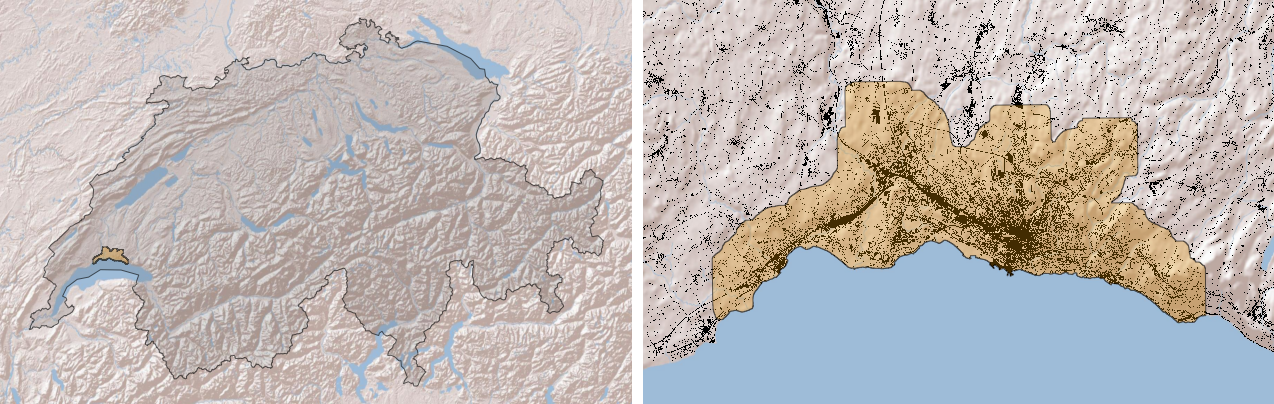

In [8]:
# update the color map to plot transparent nan values
cmap = cm.gray
cmap.set_bad('k', alpha=0)

# RGBA color to plot the agglomeration extent
agglom_extent_color = (.87, .56, .02, .3)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# get the Swiss bounds geometry
swiss_gdf = gpd.read_file(swiss_bounds_uri).to_crs(WEB_MERCATOR_CRS)

plot_country(swiss_gdf, agglom_extent_gdf, agglom_extent_color,
             esri_relief_uri, axes[0])
plot_agglom(agglom_extent_gdf, agglom_extent_color, dst_arr, dst_transform,
            cmap, esri_relief_uri, axes[1])

fig.tight_layout()
# save the figure
fig.savefig('../reports/figures/spatial-extent.pdf')